# Introduction
This notebook goes over work for the Ultimate rider retention analysis. The goal of this analysis is to build a predictive model to determine whether or not a user will be active six months after their sign up. This notebook covers work in data wrangling, exploratory data analysis and modeling. 

## Table of Contents
- [Import libraries](#section1)
- [Data Wrangling](#section2)
- [EDA](#section3)
    - [Feature Importance](#section4)
- [Modeling](#section4)

### Import libraries <a name="section1"></a>
Here we will import necessary libraries. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

### Data Wrangling
Here we will load the data and clean the data for analysis. Items addressed are handling dates, handling NAN values and labeling the data. Let's begin with getting a look at our data. Examine both its intial rows, shape and NAN values.

In [2]:
#Load data into a dataframe and inspect
rider_df = pd.io.json.read_json('ultimate_data_challenge.json')
rider_df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [3]:
#Inspect shape of our data
rider_df.shape

(50000, 12)

In [4]:
#Check columns for NAN's
rider_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

They aren't very many NAN values in avg_rating_by_driver and phone, so these can be simply dropped. The NAN's for avg_rating_of_driver are more significant, so we will have to handle these in a different manner.

In [5]:
#Since there are very few entires missing in phone and avg_rating_by_driver, we will drop these columns
rider_df = rider_df[rider_df['phone'].notna()]
rider_df = rider_df[rider_df['avg_rating_by_driver'].notna()]
rider_df.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      7961
avg_surge                    0
last_trip_date               0
phone                        0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver         0
dtype: int64

In [6]:
#Check avg_rating_of_driver column for odd entries
rider_df['avg_rating_of_driver'].unique()

array([4.7, 5. , 4.3, 4.6, 4.4, 3.5, nan, 4.5, 4. , 3.9, 4.9, 4.8, 2.5,
       3.7, 1. , 4.1, 4.2, 3. , 3.8, 2. , 2.7, 3.3, 2.8, 3.6, 3.4, 3.2,
       2.6, 3.1, 2.9, 1.7, 1.8, 1.5, 2.3, 1.9, 2.1, 2.4, 1.6, 2.2])

Let's check the avg_rating_of_driver averages by city to see if we can use these values to replace our NAN values. If the averages are significant, let's go ahead and use them as replacements. This will fix our NAN problem without being too general.

In [7]:
#Get average ratings for avg_rating_of_driver by city
#This will help us handle NAN values if the difference in averages is significant
rider_df.groupby(['city']).mean()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
city,,,,,,,,
Astapor,1.951513,4.630883,1.086268,10.132742,0.391195,60.383039,5.413241,4.798740
King's Landing,2.473521,4.707943,1.070251,9.929072,0.414880,63.201346,5.960741,4.852877
Winterfell,2.438021,4.532514,1.068241,7.461979,0.348376,60.293481,5.970368,4.730360


In [8]:
#Perform an ANova test to determine signifcance of averages
Asta = rider_df['avg_rating_of_driver'][rider_df['city'] == 'Astapor'].dropna()
King = rider_df['avg_rating_of_driver'][rider_df['city'] == "King's Landing"].dropna()
Winter = rider_df['avg_rating_of_driver'][rider_df['city'] == 'Winterfell'].dropna()
stats.f_oneway(Asta, King, Winter)

F_onewayResult(statistic=269.89543483440394, pvalue=3.489045524625433e-117)

In [9]:
#Since averages are significant we can fill NAN's with averages based on city
#Averages take from two cells above
#Fill na for Astapor
rider_df.loc[(rider_df['city']=='Astapor'), 'avg_rating_of_driver'] =\
    rider_df.loc[(rider_df['city']=='Astapor'), 'avg_rating_of_driver'].fillna(4.6)
#Fill na for King's Landing
rider_df.loc[(rider_df['city']=="King's Landing"), 'avg_rating_of_driver'] =\
    rider_df.loc[(rider_df['city']=="King's Landing"), 'avg_rating_of_driver'].fillna(4.7)
#Fill na for Winterfell
rider_df.loc[(rider_df['city']=='Winterfell'), 'avg_rating_of_driver'] =\
    rider_df.loc[(rider_df['city']=='Winterfell'), 'avg_rating_of_driver'].fillna(4.5)
#Check to see if any NAN's are left
rider_df['avg_rating_of_driver'].isna().sum()

0

Two of our columns are dates, so these will need to be converted to datatime objects for easier manipulation. We can then use these dates to label our data. A retain customer is defined as a customer who is still active after six months after signup. We can substract sign up dates from last trip dates to see who is still active in their six month. Those active will be labeled as retained.

In [11]:
#Convert dates to datetimes
rider_df['signup_date'] = pd.to_datetime(rider_df['signup_date'])
rider_df['last_trip_date'] = pd.to_datetime(rider_df['last_trip_date'])
rider_df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [12]:
#Create a new column called 'retained' telling us whether a user was retained 6 months after signup or not. 
#1 for retained and 0 for not retained. 
rider_df['retained'] = np.where(((rider_df['last_trip_date'] - rider_df['signup_date'])\
                                / np.timedelta64(1, 'M')) >= 5, 1, 0)
rider_df['retained'].value_counts()

0    38305
1    11101
Name: retained, dtype: int64

In [47]:
rider_df['retained'].value_counts()[1]/len(rider_df)

0.22468930899081083

We can see that roughly 22% percent of users are retained.

In [13]:
#Now that a label has been made, the dates have served their purpose and can be dropped.
#Dropping these columns helps eliminate redudancy in the data
rider_df.drop(['signup_date', 'last_trip_date'], axis=1, inplace=True)
rider_df.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,King's Landing,4,4.7,1.10,iPhone,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,5.0,1.00,Android,0.0,False,50.0,8.26,5.0,0
2,Astapor,3,4.3,1.00,iPhone,0.0,False,100.0,0.77,5.0,0
3,King's Landing,9,4.6,1.14,iPhone,20.0,True,80.0,2.36,4.9,1
4,Winterfell,14,4.4,1.19,Android,11.8,False,82.4,3.13,4.9,0


### EDA <a name="section2"></a>
Now that the data has be cleaned and wrangled for analysis, let's start our analysis by looking at some distributions. Let's examine retention rates by a few different features.

In [14]:
#To make the data easier to read
plt.rcParams['figure.figsize'] = (10, 10)
sns.set()

Text(0.5, 1.0, 'Retention by phone')

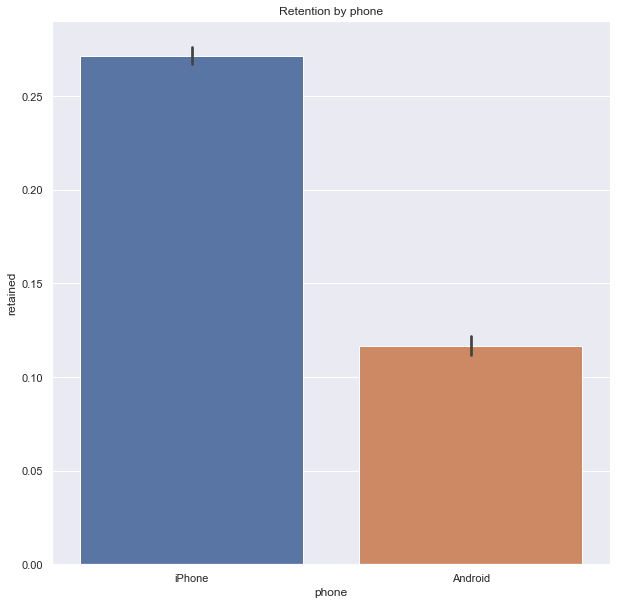

In [15]:
#Plot retention by phone type
sns.barplot(x='phone', y='retained', data=rider_df)
plt.title('Retention by phone')

Text(0.5, 1.0, 'Retention by whether or not ultimate black user')

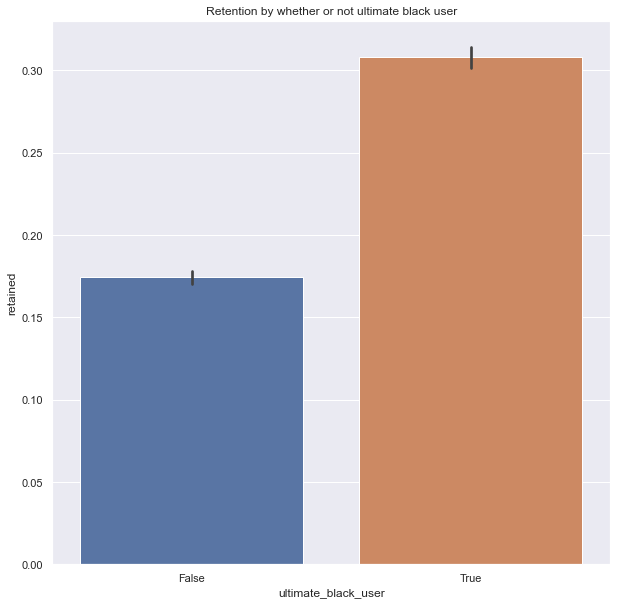

In [16]:
#Plot retetnion by whether or not they are a ultimate black user
sns.barplot(x='ultimate_black_user', y='retained', data=rider_df)
plt.title('Retention by whether or not ultimate black user')

Text(0.5, 1.0, 'Retention by city')

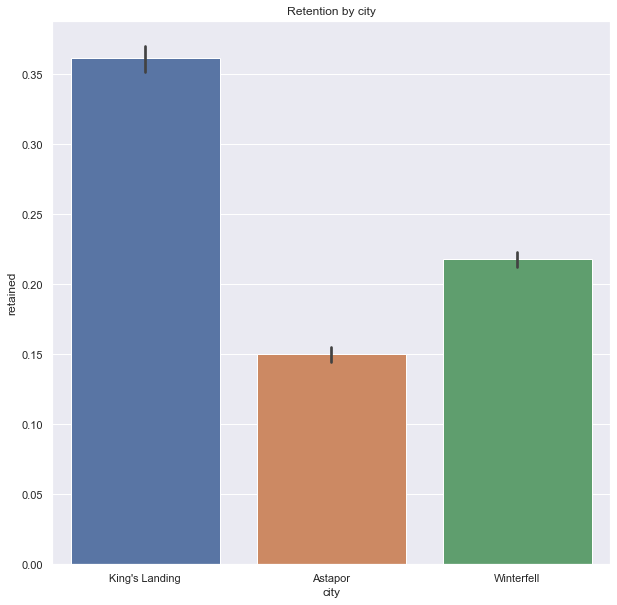

In [17]:
#Plot retention by city
sns.barplot(x='city', y='retained', data=rider_df)
plt.title('Retention by city')

Let's now check these plots for statistical significance using a anova tests for the cities and the t-test for the other plots.

In [18]:
#Check for statistical significance of above charts
print(stats.f_oneway(rider_df['retained'][rider_df['city']=='Astapor'],
                      rider_df['retained'][rider_df['city']=="King's Landing"],
                      rider_df['retained'][rider_df['city']=='Winterfell']))
print(stats.ttest_ind(rider_df['retained'][rider_df['ultimate_black_user']==True],
                      rider_df['retained'][rider_df['ultimate_black_user']==False]))
print(stats.ttest_ind(rider_df['retained'][rider_df['phone']=='iPhone'],
                      rider_df['retained'][rider_df['phone']=='Android']))

F_onewayResult(statistic=831.4984327718112, pvalue=0.0)
Ttest_indResult(statistic=34.87932528906425, pvalue=2.456151811723234e-263)
Ttest_indResult(statistic=38.45824074795299, pvalue=0.0)


With our results coming back showing significance, let's now ensure we don't have variables that are too correlated. 

We can see that avg_surge and surge_pct are quite correlated. They are just below the threshold of 80% correlated, so we can leave them for now.

Text(0.5, 1.0, 'Heatmap')

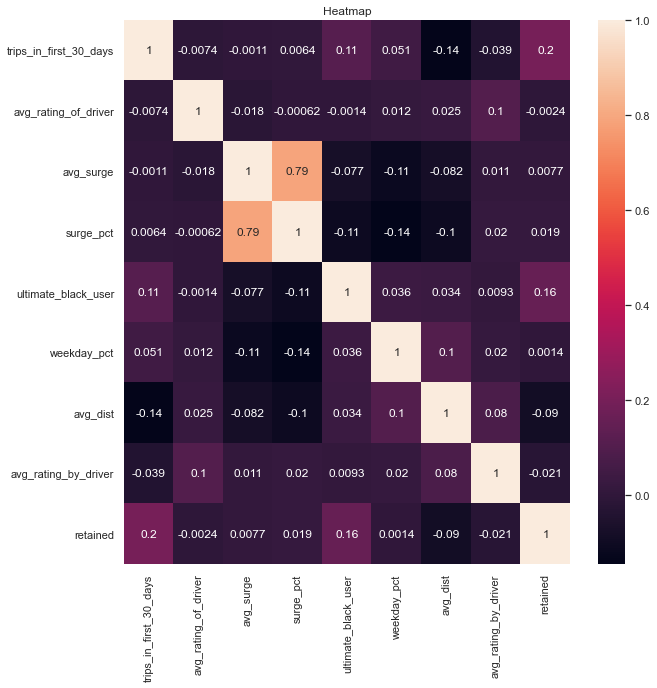

In [19]:
#Plot a heatmap to check for too high correlation between variables. 
sns.heatmap(rider_df.corr(), annot=True)
plt.title('Heatmap')

#### Feature Importance <a name="section4"></a>
Let's explore the data in one last way, and that is to see which features are most important for making predictions. We will do this by training a model on the data. From this model we can pull feature importance and graph them. Before this, however, we need to handle categorical data. We will do this by one hot encoding the data.

In [21]:
#Here a little preprocessing will be done so most predictive features can be found
#This will also help with process data for final modeling
#One get dummies to turn city and phone type into numerical values
model_df = pd.get_dummies(rider_df, drop_first=True)
model_df.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,retained,city_King's Landing,city_Winterfell,phone_iPhone
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,0,1,0,1
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,0,0,0,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,0,0,0,1
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,1,1,0,1
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,0,0,1,0


In [22]:
from sklearn.preprocessing import RobustScaler
#Get dependent and independent features from datafrome
X_feat = model_df.drop('retained', axis=1)
y_feat = model_df['retained']
#Create a scaler to scale X data. Y is just 1's and 0's so it doesn't need to be scaled
robust = RobustScaler()
X_feat = pd.DataFrame(robust.fit_transform(X_feat), columns=model_df.drop('retained', axis=1).columns)

In [23]:
#Here will we train a random classifier model to get most predictive features
#Data won't be split as this model will be seperate from final model
from sklearn.ensemble import RandomForestClassifier
#Create and train model
feature_forest_class = RandomForestClassifier(random_state=10)
feature_forest_class.fit(X_feat, y_feat)

RandomForestClassifier(random_state=10)

Text(0.5, 1.0, 'Features by predictive importance')

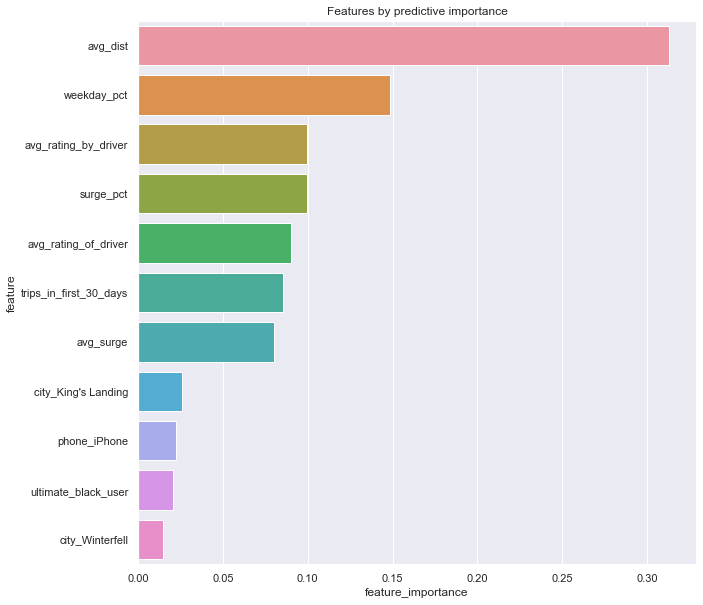

In [24]:
impor_feat = pd.DataFrame({'feature': X_feat.columns, 'feature_importance': 
                           [abs(i) for i in feature_forest_class.feature_importances_]})
sns.barplot(x='feature_importance', y='feature',
           data=impor_feat.sort_values('feature_importance', ascending=False).head(15))
plt.title('Features by predictive importance')

### Modeling <a name="section3"></a>
Now that we have explored the data, we can see that avg_dist is the biggest player when it comes to feature importance. This is interesting as this data only applies to the first thirty days and our target variable deals with activity after 6 months. This may be an area of importance.

In [26]:
#Import new libraries for modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
#Get independant and dependant variables
X = model_df.drop('retained', axis=1)
y = model_df['retained']

#Split for modeling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)

#Scale data
robust = RobustScaler()
X_train = pd.DataFrame(robust.fit_transform(X_train), columns=model_df.drop('retained', axis=1).columns)
#Just transform the data this time so that it is transformed in the same manner as training
X_test = pd.DataFrame(robust.transform(X_test), columns=model_df.drop('retained', axis=1).columns)

In [32]:
#Begin with k_neighbors
from sklearn.neighbors import KNeighborsClassifier
#Intialize classifier 
knn = KNeighborsClassifier()
#Create a parameter grid for cross validation
param_grid_knn = {'n_neighbors': np.arange(1, 50)}
#Gridsearch with roc_auc as scoring
knn_gs = GridSearchCV(knn, param_grid_knn, cv=5, scoring='roc_auc')
#Train GridSearch
knn_gs.fit(X_train.values, y_train)
#Print results
print('Best parameter for n_neighbors is {}'.format(knn_gs.best_params_['n_neighbors']))
print('Scoring {}'.format(knn_gs.best_score_))

Best parameter for n_neighbors is 44
Scoring 0.781712149751413


In [34]:
#Now that we have the best n_neighbors, we can make a model with this value. 
knn_final = KNeighborsClassifier(n_neighbors=44)
#Fit model. Fitted with .values to stop warnings
knn_final.fit(X_train.values, y_train)

KNeighborsClassifier(n_neighbors=44)

              precision    recall  f1-score   support

           0       0.82      0.94      0.88      9549
           1       0.59      0.32      0.41      2803

    accuracy                           0.80     12352
   macro avg       0.71      0.63      0.64     12352
weighted avg       0.77      0.80      0.77     12352



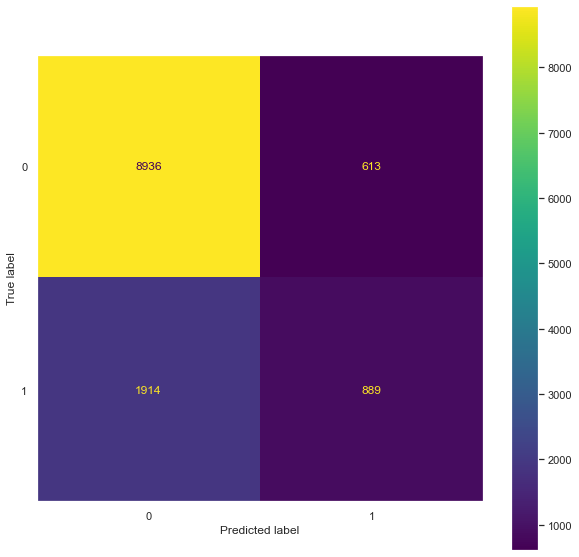

In [37]:
#Import libraries for exmaining confusion matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
#Get predictions
knn_pred = knn_final.predict(X_test.values)
#Create confusion matrix and display
knn_cm = confusion_matrix(y_test, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=knn_cm)
disp.plot()
plt.grid(False)
print(classification_report(y_test, knn_pred))

We can see that this neighbor model is alright, but not the best. Let's see if a random forest classifier can do any better.

In [41]:
#Let's try RandomForest
from sklearn.ensemble import RandomForestClassifier
#Intialize classifier 
forest = RandomForestClassifier(random_state=10)
#Create a parameter grid for cross validation
param_grid_forest = { 
    'n_estimators': [10, 100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 3, 5, 7, 9],
}
#Gridsearch with roc_auc as scoring
forest_gs = GridSearchCV(forest, param_grid_forest, cv=5, scoring='roc_auc')
#Train GridSearch
forest_gs.fit(X_train.values, y_train)
#Print results
print('Best parameter for n_neighbors is {}'.format(forest_gs.best_params_))
print('Scoring {}'.format(forest_gs.best_score_))

Best parameter for n_neighbors is {'max_depth': 9, 'max_features': 'auto', 'n_estimators': 500}
Scoring 0.8094216237013386


              precision    recall  f1-score   support

           0       0.83      0.94      0.88      9549
           1       0.62      0.33      0.43      2803

    accuracy                           0.80     12352
   macro avg       0.73      0.64      0.66     12352
weighted avg       0.78      0.80      0.78     12352



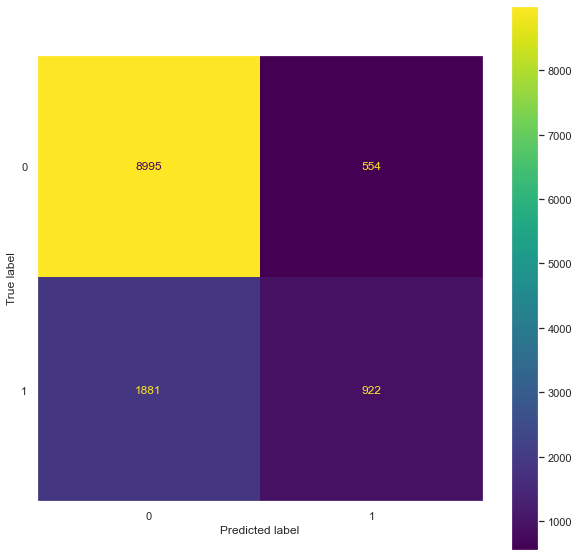

In [43]:
#Let's make a model with these values
forest_final = RandomForestClassifier(max_depth=9, max_features ='auto', n_estimators=500)
#Fit model
forest_final.fit(X_train, y_train)
#Get preditions
forest_pred = forest_final.predict(X_test)
#Make and display confusion matrix
forest_cm = confusion_matrix(y_test, forest_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=forest_cm)
disp.plot()
plt.grid(False)
print(classification_report(y_test, forest_pred))

We get a little improvement, but not a lot. Let's compare the two models before making final conclusions. 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: RocCurveDisplay.from_predictions or RocCurveDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'ROC curves of two models')

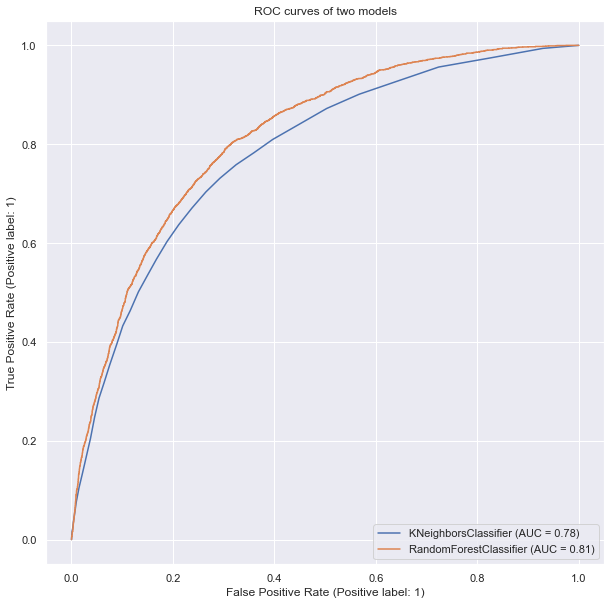

In [44]:
#Let's plot both of these models' roc curves
from sklearn.metrics import plot_roc_curve
disp = plot_roc_curve(knn_final, X_test, y_test)
plot_roc_curve(forest_final, X_test, y_test, ax=disp.ax_)
plt.title('ROC curves of two models')

This chart confirms that the Random Forest is better, but still not great. More feature analysis could prove useful to improve these numbers. Also, if this chart is acceptable, thresholding could be performed to increase recall or precision as desired. 

Ultimate can leverage the most useful information from the feature importance graph. This graph shows which areas need more focus so that customers can be retained. 